# Imports

In [ ]:
# run this to fix or avoid dataloader warnings and data loading incorrectly
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 48.6MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.4.0 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate

In [ ]:
!ls /usr/local/lib/python3.7/dist-packages/fastai

basic_data.py	datasets.py	      metrics.py	  train.py
basics.py	distributed.py	      __pycache__	  utils
basic_train.py	gen_doc		      script.py		  version.py
callback.py	general_optimizer.py  sixel.py		  vision
callbacks	imports		      tabular		  widgets
collab.py	__init__.py	      test_registry.json
core.py		launch.py	      text
data_block.py	layers.py	      torch_core.py


In [ ]:
!cat /usr/local/lib/python3.7/dist-packages/fastai/version.py

__all__ = ['__version__']
__version__ = '1.0.61'


# Download data

In [ ]:
api_token = {"username": "x", "key": "y"} #
!mkdir -p ~/.kaggle/
with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!ls -la /root/.kaggle/

total 16
drwxr-xr-x 2 root root 4096 Apr 17 05:20 .
drwx------ 1 root root 4096 Apr 17 05:20 ..
-rw------- 1 root root   73 Apr 17 05:20 kaggle.json


In [ ]:
path = Config.data_path()/'breast-cancer'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/breast-cancer')

In [ ]:
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset -p {path}

 91% 177M/195M [00:00<00:00, 176MB/s]
100% 195M/195M [00:00<00:00, 209MB/s]


In [ ]:
path.ls()

In [ ]:
!unzip -q -n {path}/breast-ultrasound-images-dataset.zip -d {path}

In [ ]:
path.ls()

[PosixPath('/root/.fastai/data/breast-cancer/breast-ultrasound-images-dataset.zip'),
 PosixPath('/root/.fastai/data/breast-cancer/Dataset_BUSI_with_GT')]

In [ ]:
!ls -la /root/.fastai/data/breast-cancer/Dataset_BUSI_with_GT #/models

total 76
drwxr-xr-x 5 root root  4096 Apr 24 14:43 .
drwxr-xr-x 3 root root  4096 Apr 24 14:43 ..
drwxr-xr-x 2 root root 36864 Apr 24 14:43 benign
drwxr-xr-x 2 root root 20480 Apr 24 14:43 malignant
drwxr-xr-x 2 root root 12288 Apr 24 14:43 normal


In [ ]:
path = path/'Dataset_BUSI_with_GT'

# Prepare data

In [ ]:
def delete_files(file_list):
  for bf in file_list:
    try:
      os.remove(bf)
    except OSError as e:
      print("Error: %s : %s" % (bf, e.strerror))

In [ ]:
duplicated_masks = list(sorted(path.rglob('*_mask_*')))
len(duplicated_masks)
duplicated_masks

[PosixPath('/root/.fastai/data/breast-cancer/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png'),
 PosixPath('/root/.fastai/data/breast-cancer/Dataset_BUSI_with_GT/benign/benign (163)_mask_1.png'),
 PosixPath('/root/.fastai/data/breast-cancer/Dataset_BUSI_with_GT/benign/benign (173)_mask_1.png'),
 PosixPath('/root/.fastai/data/breast-cancer/Dataset_BUSI_with_GT/benign/benign (181)_mask_1.png'),
 PosixPath('/root/.fastai/data/breast-cancer/Dataset_BUSI_with_GT/benign/benign (195)_mask_1.png'),
 PosixPath('/root/.fastai/data/breast-cancer/Dataset_BUSI_with_GT/benign/benign (195)_mask_2.png'),
 PosixPath('/root/.fastai/data/breast-cancer/Dataset_BUSI_with_GT/benign/benign (25)_mask_1.png'),
 PosixPath('/root/.fastai/data/breast-cancer/Dataset_BUSI_with_GT/benign/benign (315)_mask_1.png'),
 PosixPath('/root/.fastai/data/breast-cancer/Dataset_BUSI_with_GT/benign/benign (346)_mask_1.png'),
 PosixPath('/root/.fastai/data/breast-cancer/Dataset_BUSI_with_GT/benign/benign (4)_mask_1.png'),
 Po

In [ ]:
delete_files(duplicated_masks)

In [ ]:
mask_files = list(sorted(path.rglob('*[_mask].png')))
len(mask_files), mask_files[0]

(780,
 PosixPath('/root/.fastai/data/breast-cancer/Dataset_BUSI_with_GT/benign/benign (1)_mask.png'))

In [ ]:
delete_files(mask_files)

In [ ]:
img_files = list(sorted(path.rglob('*[!_mask].png')))
len(img_files), img_files[0]

(780,
 PosixPath('/root/.fastai/data/breast-cancer/Dataset_BUSI_with_GT/benign/benign (1).png'))

# Load data

In [ ]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize() #imagenet_stats)

In [ ]:
np.random.seed(42)
data = ImageDataBunch.from_lists(
  path, fnames=img_files, valid_pct=0.2, labels=['benign', 'malignant', 'normal'],
  ds_tfms=get_transforms(), size=224, num_workers=4
).normalize(imagenet_stats)

In [ ]:
dls = (ImageList.from_folder(path, recurse=True)
       .split_by_rand_pct()
       .label_from_folder()
       .transform(get_transforms(), size=224)
       .databunch(bs=8, path=path)
        # .normalize()
        .normalize(imagenet_stats)
       )

In [ ]:
data.classes

['benign', 'malignant', 'normal']

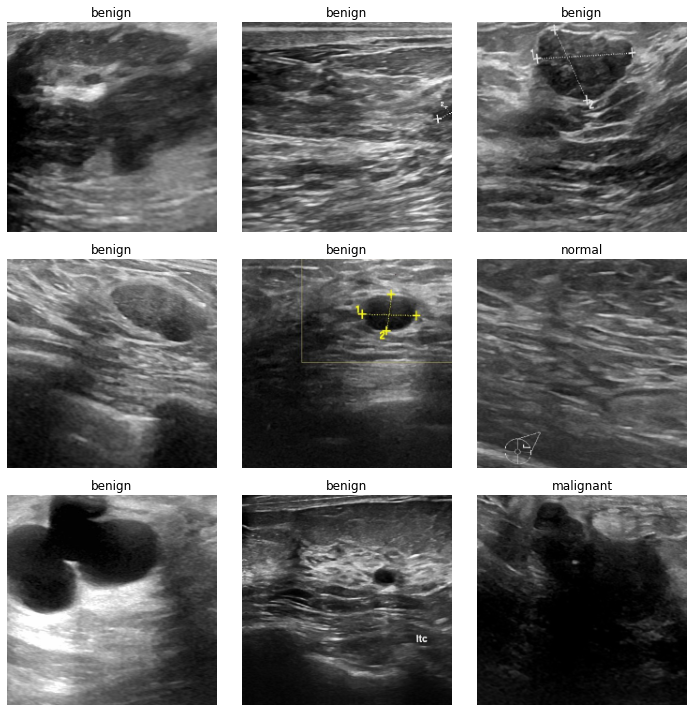

In [ ]:
data.show_batch(rows=3, figsize=(10,10))

In [ ]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['benign', 'malignant', 'normal'], 3, 624, 156)

# Model resnet34

In [ ]:
f1_score = partial(fbeta, thresh=0.2)

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
# learn = cnn_learner(data, models.resnet34, metrics=fbeta)

In [ ]:
learn.summary()

## Train stage 1

In [ ]:
# raw normalized
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.914564,1.037788,0.435897,00:17
1,1.618648,1.826286,0.480769,00:17
2,1.502155,1.511907,0.461538,00:17
3,1.367908,1.245665,0.423077,00:17


In [ ]:
# imagenet normalized
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.816584,2.482499,0.589744,00:17
1,1.631927,2.066596,0.474359,00:17
2,1.419983,1.991421,0.500000,00:17
3,1.332475,1.727609,0.467949,00:17


In [ ]:
learn.save('rn34-stage-1');

In [ ]:
learn.load('rn34-stage-1')

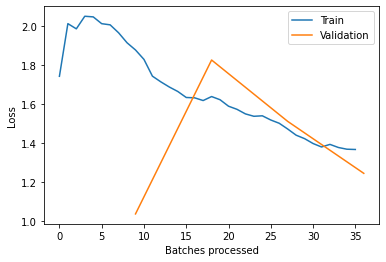

In [ ]:
# raw normalized
learn.recorder.plot_losses()

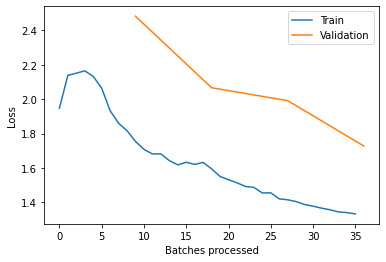

In [ ]:
# imagenet normalized
learn.recorder.plot_losses()

In [ ]:
learn.unfreeze()

In [ ]:
# raw normalized
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [ ]:
# imagenet normalized
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


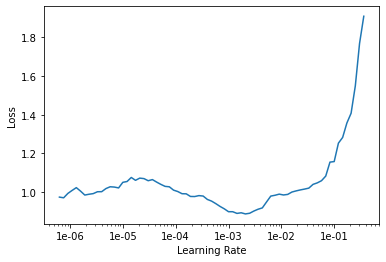

In [ ]:
learn.recorder.plot()

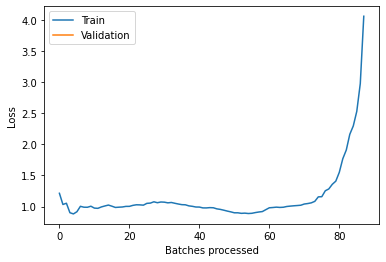

In [ ]:
learn.recorder.plot_losses()

In [ ]:
# raw normalized
learn.fit_one_cycle(5, max_lr=slice(1e-04,1e-02/3))

epoch,train_loss,valid_loss,error_rate,time
0,1.054492,1.356930,0.410256,00:17
1,1.005304,1.479770,0.346154,00:17
2,0.879181,1.834969,0.307692,00:17
3,0.766239,0.991130,0.243590,00:17
4,0.659554,0.761010,0.205128,00:17


In [ ]:
# imagenet normalized
learn.fit_one_cycle(5, max_lr=slice(1e-04,1e-02/3))

epoch,train_loss,valid_loss,error_rate,time
0,1.163597,1.199511,0.397436,00:17
1,0.984036,1.815658,0.346154,00:17
2,0.895869,1.819635,0.365385,00:17
3,0.742936,0.899266,0.243590,00:17
4,0.623994,0.827942,0.198718,00:17


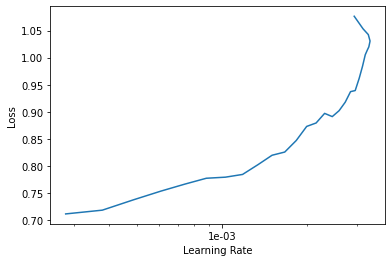

In [ ]:
# raw normalized
learn.recorder.plot()

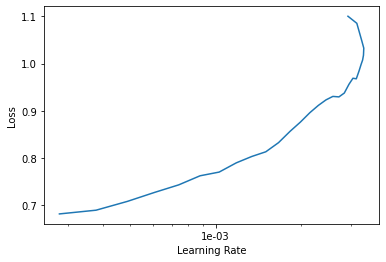

In [ ]:
# imagenet normalized
learn.recorder.plot()

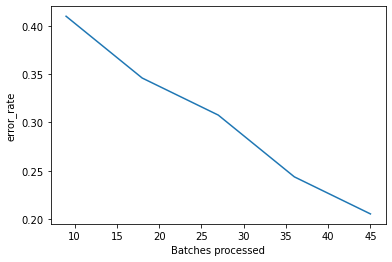

In [ ]:
# raw normalized
learn.recorder.plot_metrics()

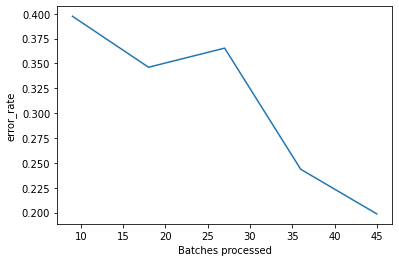

In [ ]:
# imagenet normalized
learn.recorder.plot_metrics()

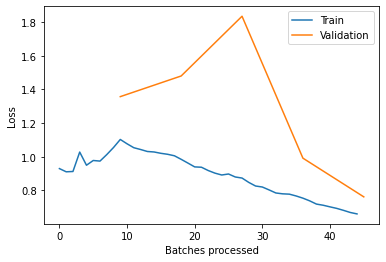

In [ ]:
# raw normalized
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-2')

In [ ]:
learn.load('stage-2')

## Interpretation

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

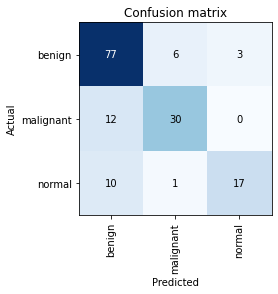

In [ ]:
# raw normalized rn34
interp.plot_confusion_matrix()

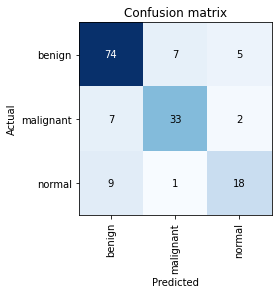

In [ ]:
# imagenet normalized rn34
interp.plot_confusion_matrix()

### Top losses

In [ ]:
losses, idxs = interp.top_losses()

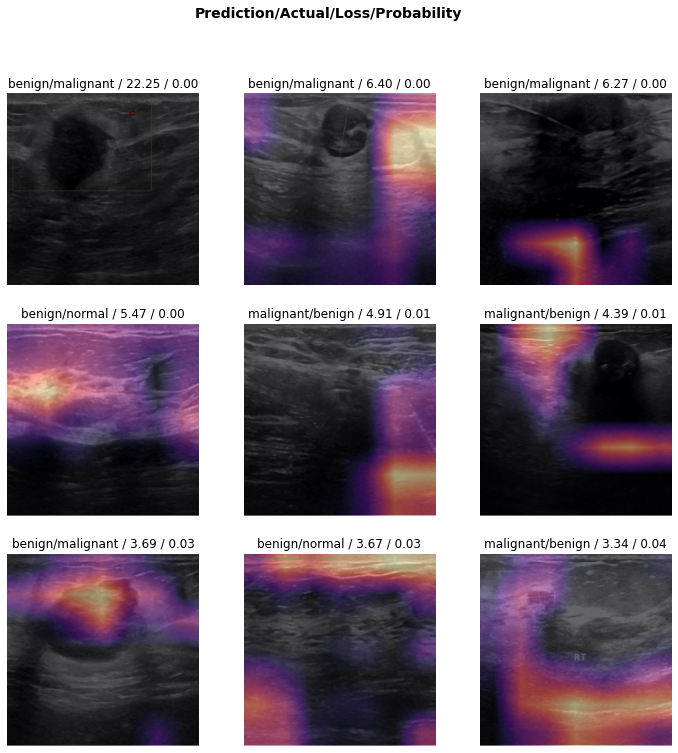

In [ ]:
# raw normalized rn34
interp.plot_top_losses(9, figsize=(12, 12), heatmap=True)

# Model resnet50

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


## Train stage 1

In [ ]:
# raw normalized
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.695095,1.847277,0.519231,00:18
1,1.607411,4.930884,0.647436,00:18
2,1.430129,4.448888,0.673077,00:18
3,1.263735,4.050974,0.641026,00:18


In [ ]:
learn.save('rn50-stage-1');

## stage 1 results

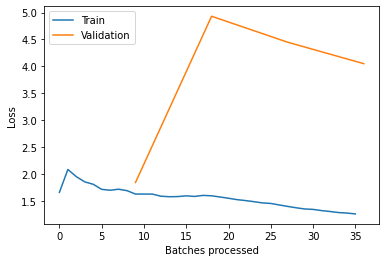

In [ ]:
# raw normalized
learn.recorder.plot_losses()

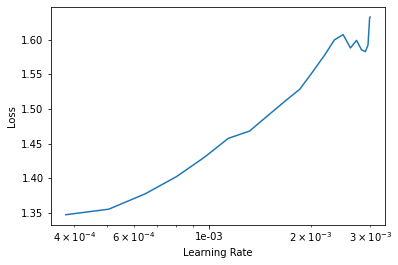

In [ ]:
learn.recorder.plot()

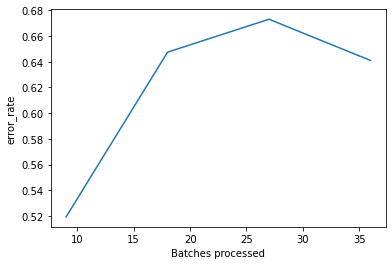

In [ ]:
learn.recorder.plot_metrics()

## stage 2 unfreeze

In [ ]:
learn.unfreeze()

In [ ]:
# raw normalized
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


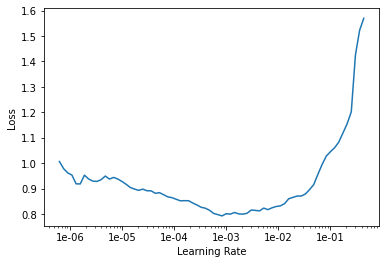

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, max_lr=slice(1e-06,1e-03))

epoch,train_loss,valid_loss,error_rate,time
0,0.920882,3.063435,0.538462,00:18
1,0.900249,2.409486,0.506410,00:18
2,0.806917,1.692265,0.435897,00:18
3,0.764402,1.152368,0.391026,00:18
4,0.719055,1.000097,0.352564,00:18


## stage 2 results

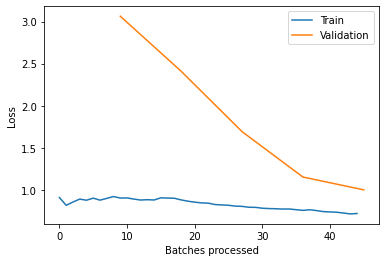

In [ ]:
learn.recorder.plot_losses()

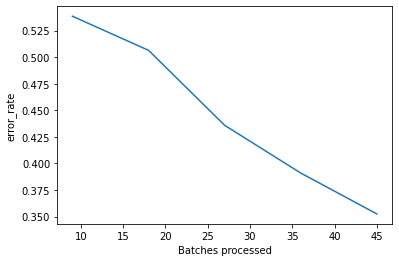

In [ ]:
learn.recorder.plot_metrics()

## Interpretation

### confusion

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

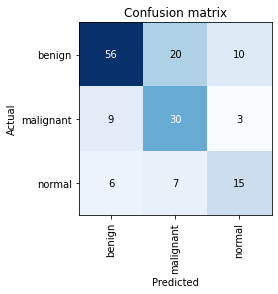

In [ ]:
# raw normalized rn50
interp.plot_confusion_matrix()

### Top losses

In [ ]:
losses, idxs = interp.top_losses()

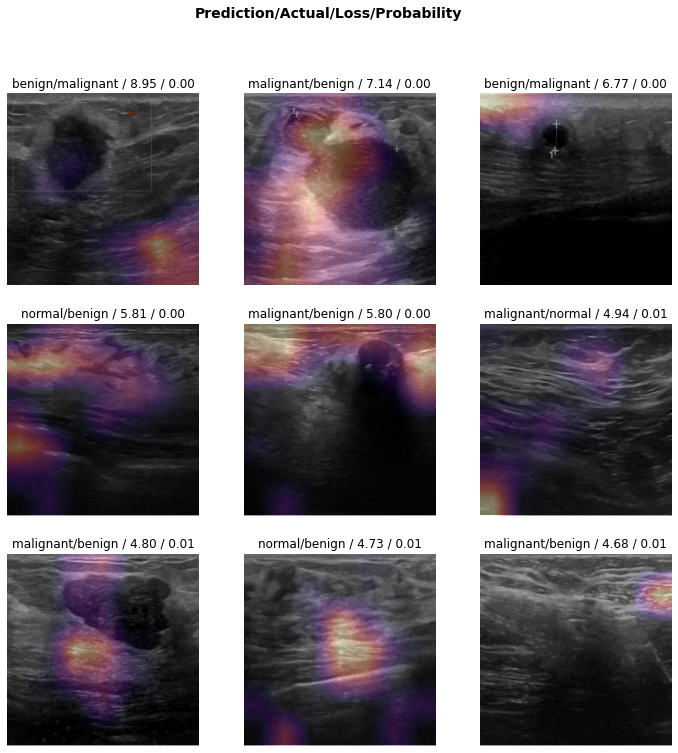

In [ ]:
# raw normalized rn50
interp.plot_top_losses(9, figsize=(12, 12), heatmap=True, alpha=0.4)